     ML Project 2020

Project requirement: The goal is to produce a model that accurately predicts wind turbine power output from wind speed values, as in the data set. You must then develop a web service that will respond with predicted power values based on speed values sent as HTTP requests.


import the required packages for the program

In [111]:
# For data frames.
import pandas as pd
import seaborn as sns

# For numerical arrays.
import numpy as np

# For plotting
import matplotlib.pyplot as plt
#%matplotline inline

#For maths
import math as m

# For linear regression.
from sklearn import linear_model

# For evaluating model performance.
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics

# For splitting data into train / test sets.
from sklearn.model_selection import train_test_split
#import sklearn.model_selection as skms

from scipy.optimize import curve_fit

import sklearn.preprocessing as skpp
import sklearn.metrics as skme
import tensorflow.keras as kr
from keras.models import model_from_json


In [2]:
plt.rcParams['figure.figsize'] = (8.0, 6.0) 

<b>PowerProduction Dataset</b>


In [3]:
# File provided as a txt file. I saved it as a csv file.
Power_data = pd.read_csv("data\powerproduction.csv")

# Make a copy of the original dataset in case we need it later.
Power_data_copy = Power_data

# Size?
shape = Power_data.shape
print("Data frame shape", shape, "r,c")

# Check for NaNs, missing values etc
print(Power_data.count())

Data frame shape (500, 2) r,c
speed    500
power    500
dtype: int64


In [4]:
# Have a look at the data from our Power Production input
Power_data

,speed,power
0,0.000,0.0
1,0.125,0.0
2,0.150,0.0
3,0.225,0.0
4,0.275,0.0
...,...,...
495,24.775,0.0
496,24.850,0.0
497,24.875,0.0
498,24.950,0.0


Since the power column has zero output from the above we will check few lines from top and bottom of the file



In [5]:
# Print firdt 20 rows
Power_data.head(20)

,speed,power
0,0.000,0.000
1,0.125,0.000
2,0.150,0.000
3,0.225,0.000
4,0.275,0.000
5,0.325,4.331
6,0.400,5.186
7,0.450,3.826
8,0.501,1.048
9,0.526,5.553


In [6]:
Power_data.tail(20)

,speed,power
480,23.974,94.270
481,24.024,105.992
482,24.049,93.524
483,24.174,95.869
484,24.199,101.419
485,24.249,103.700
486,24.299,93.694
487,24.349,93.078
488,24.374,98.223
489,24.399,95.117


Looking at the raw data it is noted that wind speeds 0.275 and below generate no power, wind speeds 24.499 generate no power. Even from the above description the power for the low and high level wind speed power has taken zero value. So we will look at some more rows from the top to find the data for Power column.

In [11]:
# Look at some quick descriptive statistics of the numeric data.
print(Power_data.describe())

            speed       power
count  486.000000  486.000000
mean    12.298311   49.397720
std      7.084043   41.391996
min      0.000000    0.000000
25%      6.137250    5.868250
50%     12.349500   44.773000
75%     18.386750   93.751250
max     24.399000  113.556000


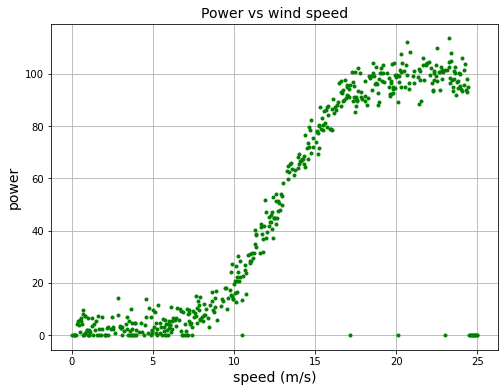

In [8]:
# Try plotting power as a function of wind speed to check for any obvious relationship between them.
plt.plot(Power_data['speed'], Power_data['power'],  '.g')
plt.title('Power vs wind speed', fontsize='14')
plt.xlabel('speed (m/s)', fontsize='14')
plt.ylabel('power', fontsize='14')
plt.grid()

With the given data we can see that there is little power is generated until some threshold speed is achieved (about 7 m/s), then it increases nearly linearly in a range of wind speeds (8 - 17 m/s), before saturating above a certain wind speed (about 17 m/s). The plot would suggest there is a range of wind speeds where the power seems to increase linearly with wind speed. 

I would like to do some cleanup to remove the zero power just to make it clear while finding the promising model

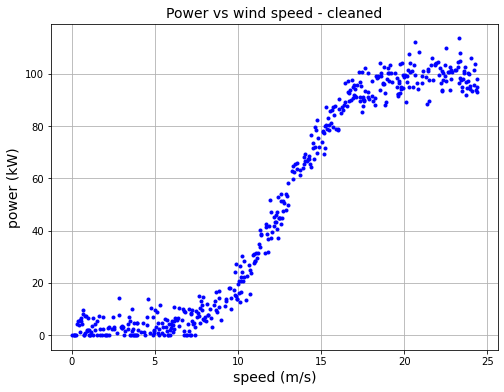

In [9]:
# Remove the rows with zero values to Power column from my existing dataset.
Power_data.drop(Power_data.loc[(Power_data.power == 0) & (Power_data.speed > 10)].index, inplace=True)

plt.plot(Power_data['speed'], Power_data['power'],  '.b')
plt.title('Power vs wind speed - cleaned', fontsize='14')
plt.xlabel('speed (m/s)', fontsize='14')
plt.ylabel('power (kW)', fontsize='14')
plt.grid()

<b>Formula used in real life to calculate the Power of Wind</b>

In order to calculate the amount of energy the wind speed is very important to convert it to electricity. The energy content of the wind varies with the cube of the avereate  wind speed, e.g. if the wind speed is twice as high it contains 2^3 = 2x2x2 = eight times as much energy [1]



![Power_of_wind](images/Power_of_wind.jpg)


<b>Power Curve of a Wind Turbine</b>

The power curve of a wind turbine is a graph that indicates how large the electrical power output will be for the turbine at different wind speeds[2] At the same time this curve will not show how much power a wind turbine will produce at a certain average wind speed.

When the anemometer registers wind speeds higher than 25 mph (cut-out speed varies by turbine), it triggers the wind turbine to automatically shut off and resumes back to normal when the measurement of wind speed are at or below the turbine's cut-out speed[4]  

![Power_curve](images/Power_curve.jpg)

![Power_curve2](images/Wind_Power_curve.jpg)

The theoretical power curve for a turbine is specific to each turbine and site [3]. Based on the above graph  
 - The cut-in speed is the threshold wind speed that much be reached before the turbine will start to generate electricity. A typical value is about 4 m/s.
 - The rated output power is achieved at approximately 14 - 15 m/s.
 - The cut-out speed is the wind speed at which the turbine will stop producing electricity in order to avoid damage; typically 25 m/s.
 
While comparing this curve with the plot diagram on our cleaned dataset is nearly closer but we will start to apply some regression methods to find the best model for our Power production dataset.

## Prepare Dataset 

In order to prepare our dataset for investigations, it is better to remove unwanted results like zero output from it to find a best model. So that I am going to use the last cleaned dataset hear after.

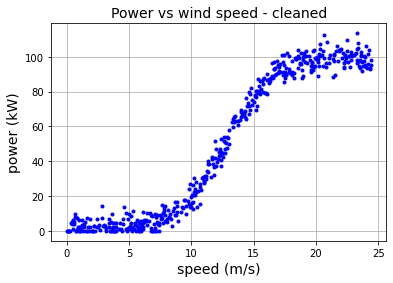

In [54]:
# Remove the rows with zero values to Power column from my existing dataset.
Cleaned_Power_Data =  Power_data

#Power_data.drop(Power_data.loc[(Power_data.power == 0) & (Power_data.speed > 10)].index, inplace=True)

plt.plot(Cleaned_Power_Data['speed'], Cleaned_Power_Data['power'],  '.b')
plt.title('Power vs wind speed - cleaned', fontsize='14')
plt.xlabel('speed (m/s)', fontsize='14')
plt.ylabel('power (kW)', fontsize='14')
plt.grid()

### Applying Linear regression 

Linear regression uses the relationship between the data-points to draw a straight line through all them. This line can be used to predict future values. It is a very powerful technique and can be used to understand the factors that influence profitability.[5] 


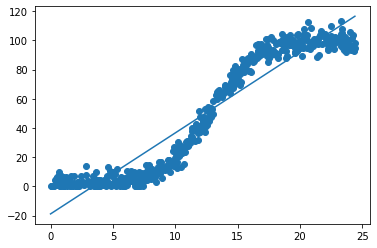

In [18]:
# https://www.w3schools.com/python/python_ml_linear_regression.asp
x = Power_data['speed'].tolist()
y = Power_data['power'].tolist()

slope, intercept, r, p, std_err = stats.linregress(x, y)

def myfunc(x):
  return slope * x + intercept

mymodel = list(map(myfunc, x))

plt.scatter(x, y)
plt.plot(x, mymodel)
plt.show()

From the above graph, you will a line straight in the middle of the data, means that there are large parts of the data untouched by the line where a linear prediction of the coordinates of speed to power would be very out of sync with where most of the data is. 

If we try to eliminate the data where speed and power are zero then we could get a good model with linear regression.

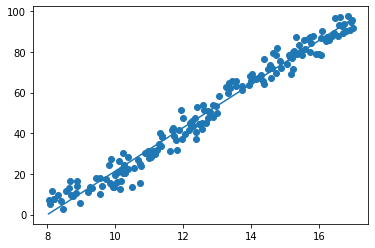

In [21]:
# https://www.w3schools.com/python/python_ml_linear_regression.asp

# Cleaniing the dataset by removing the zero values
cleansed_data = Power_data.loc[Power_data['power'] > 0 ]

Medium_set_data = cleansed_data.loc[(cleansed_data['speed'] > 8) & (cleansed_data['speed']<= 17)]

x = Medium_set_data['speed'].tolist()
y = Medium_set_data['power'].tolist()

slope, intercept, r, p, std_err = stats.linregress(x, y)

def myfunc(x):
  return slope * x + intercept

mymodel = list(map(myfunc, x))

plt.scatter(x, y)
plt.plot(x, mymodel)
plt.show()


In [22]:
Medium_set_data.describe().round(2)

,speed,power
count,172.00,172.00
mean,12.66,49.93
std,2.58,27.97
min,8.03,3.00
25%,10.38,24.26
50%,12.55,47.31
75%,14.92,76.70
max,16.99,97.53


In [26]:
# Count low medium and high wind speed ranges. Code adapted from
# https://www.kite.com/python/answers/how-to-count-the-number-of-rows-in-a-pandas-dataframe-in-python
df_cnt = len(Power_data.index)

med_s_cnt = len(Medium_set_data.index)

# Print % of low medium and high wind speed ranges.
# Code adapted from https://pyformat.info/
print(f"Medium speed range: 8 to 18 m/s = {(med_s_cnt/df_cnt)*100:.1f}%")


Medium speed range: 8 to 18 m/s = 35.4%


<b> Summary plot of relationship for Medium Wind Speed range </b>

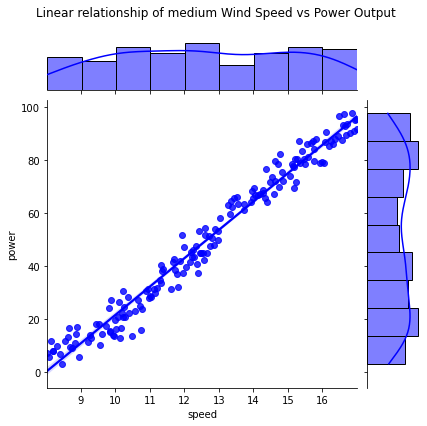

In [52]:
# Plot comparison of medium wind speed versus power output
# Code adapted from https://seaborn.pydata.org/tutorial/distributions.html#plotting-univariate-distributions 
# and https://seaborn.pydata.org/generated/seaborn.jointplot.html#seaborn.jointplot
plot = sns.jointplot(x="speed", y="power", kind="reg", color="b", height=6, data=Medium_set_data)

# Add Title adapted from https://stackoverflow.com/a/52096280
plt.subplots_adjust(top=0.90)
plt.suptitle("Linear relationship of medium Wind Speed vs Power Output", fontsize = 12)
# Display plot
plt.show()


<b> Display plot of cleaned dataset </b>

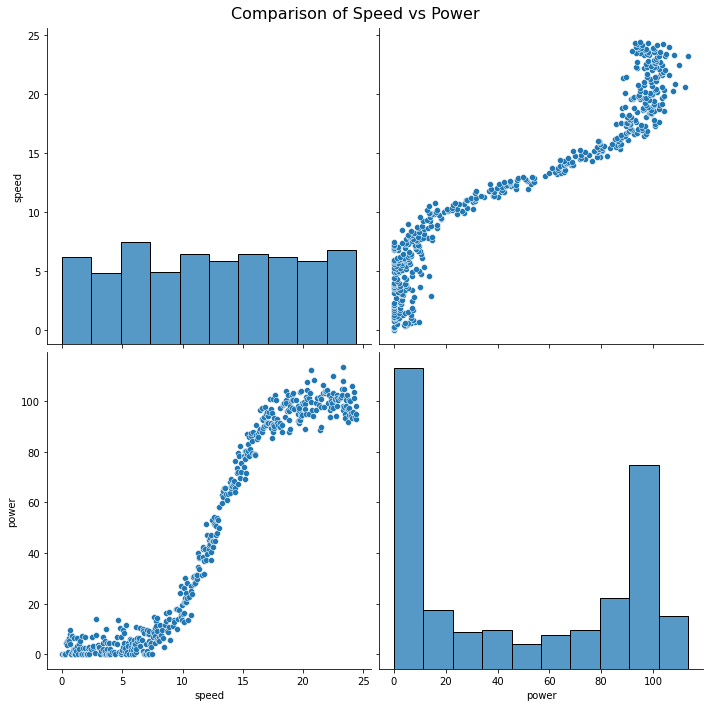

In [55]:
# Replot data comparison 
plot = sns.pairplot(Power_data, height=5)
# Add Title 
plt.subplots_adjust(top=0.95)
plt.suptitle("Comparison of Speed vs Power", fontsize = 16)
plt.show()

#### Splitting our Data Set into Training Data and Test Data

Using scikit-learn we can divide the Power Production data set into training data and test data. 

In [114]:
# Code adopted from https://www.freecodecamp.org/news/how-to-build-and-train-linear-and-logistic-regression-ml-models-in-python/
#x =  Power_data.iloc[:, :-1].values
#y =  Power_data.iloc[:, :1].values

x = Power_data[["speed"]]
y = Power_data["power"]

print(x.shape)
print(y.shape)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)

#Build the model
from sklearn.linear_model import LinearRegression
Linear_Reg_model = LinearRegression()

#Fit the model
Linear_Reg_model.fit(x_train, y_train)

#Print coefficient
print('Coefficients: \n',Linear_Reg_model.coef_)

#print intercept of the regression equation
print('Intercept: \n', Linear_Reg_model.intercept_)


# Make predictions from the model
y_pred = Linear_Reg_model.predict(x_test)

df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df.head()



(486, 1)
(486,)
Coefficients: 
 [5.53362454]
Intercept: 
 -18.840573815452295


,Actual,Predicted
81,4.437,4.976146
378,89.047,85.850069
333,94.925,74.910093
18,0.795,-14.269800
80,1.035,4.284443


<b>Evaluating the Algorithm</b>

The final step is to evaluate the performance of algorithm. This step is particularly important to compare how well different algorithms perform on a particular dataset. For regression algorithms, three evaluation metrics are commonly used:
 - Mean Absolute Error (MAE)
 - Mean Squared Error (MSE)
 - Root Mean Squared Error (RMSE)
 

In [115]:

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


Mean Absolute Error: 10.58929884725436
Mean Squared Error: 151.17843971127354
Root Mean Squared Error: 12.295464192590435


You can see that the value of root mean squared error is 12.29, which is around 25% of the mean value of the percentages of Power energy which is 49.39. From this result we can see the impact of zero values for Speed and Power. If we get less than around 10% of Mean value of the actual dataset then it would be a good mode;

<b>Apply Train test on Medium Power data set</b>

In [118]:
# Code adopted from https://www.freecodecamp.org/news/how-to-build-and-train-linear-and-logistic-regression-ml-models-in-python/
#x =  Power_data.iloc[:, :-1].values
#y =  Power_data.iloc[:, :1].values

x = Medium_set_data[["speed"]]
y = Medium_set_data["power"]

print(x.shape)
print(y.shape)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)

#Build the model
from sklearn.linear_model import LinearRegression
Linear_Reg_model = LinearRegression()

#Fit the model
Linear_Reg_model.fit(x_train, y_train)

#Print coefficient
print('Coefficients: \n',Linear_Reg_model.coef_)

#print intercept of the regression equation
print('Intercept: \n', Linear_Reg_model.intercept_)


# Make predictions from the model
y_pred = Linear_Reg_model.predict(x_test)

df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df.head()


(172, 1)
(172,)
Coefficients: 
 [10.87956307]
Intercept: 
 -88.06952749158485


,Actual,Predicted
319,87.192,88.625456
296,69.248,76.919046
225,38.184,35.533189
229,42.485,39.079926
166,7.830,0.957937


<b>Evaluating the Algorithm</b>

In [120]:

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


Mean Absolute Error: 4.112369910254459
Mean Squared Error: 25.321496572098358
Root Mean Squared Error: 5.0320469564679495


From the result above we can see that the value of root mean squared error is 5.03, which is around 10% of the mean value of the percentages of Power energy which is 49.39.

From the above predictions and investigations it is clear that applying linear regression on a large set of data will not be good and it is quite good when there is no invalid data and a small set of data.

### Deep Learning in Keras

Deep learning is one of the most interesting and promising areas of artificial intelligence(AI) and machine learning currently. [6] It is a subfield of machine learning, and neural networks make up the backbone of deep learning algorithms. 
A deep learning neuual network is just a neural network with many hidden layers.

 - <b>Number of layers</b>
         In this model I am going to use Dense layer.
 - <b>Types of these layers</b>
         Dense layers are the most common and popular type of layers and it's just a regular neural network layer where each of its neurons is connected to the neurons of the previous and next layers.
 - <b>Number of units (neurons) in each Layer</b>
         Each dense layer has an activation function that determines the output of its neurons based on the inputs and the weights of the synapses.
 - <b>Activation Functions of each Layer</b>
         There are also many types of activation functions are avilable and I am going to try Than and Sigmoid function in my model
- <b>Input and output size</b>
    Neural network consisting of three layers: the input layer, a hidden layer with 50 neurons, and the output layer. The size of the input and output layers is determined by the data we have and what we want to predict. Having one hidden layer is a good default, but if there are more hidden layers, it's recommended to have the same number of neurons in each hidden layer
 

![Neural_network](images/Neural_network.jpg)

In [ ]:
#code adopted from https://stackabuse.com/deep-learning-in-keras-building-a-deep-learning-model/



References:

[1]. The Power of the Wind: Cube of Wind Speed, http://xn--drmstrre-64ad.dk/wp-content/wind/miller/windpower%20web/en/tour/wres/enrspeed.htm

[2]. The Power Curve of a Wind Turbine, http://xn--drmstrre-64ad.dk/wp-content/wind/miller/windpower%20web/en/tour/wres/pwr.htm

[3]. Wind Turbine Power Curve, https://www.windfarmbop.com/wind-power-plant-concepts-and-performance-indicators/wind-turbine-power-curve/

[4]. How Do Wind Turbines Survive Severe Storms?; Office of ENERGY EFFICIENCY & RENEWABLE ENERGY - USA; https://www.energy.gov/eere/articles/how-do-wind-turbines-survive-severe-storms

[5].Simple Linear Regression, https://towardsdatascience.com/linear-regression-using-python-b136c91bf0a2

[6] Deep Learning, https://stackabuse.com/deep-learning-in-keras-building-a-deep-learning-model/ 


    


[].  Machine learning methods for wind turbine condition monitoring: A review,  https://www.sciencedirect.com/science/article/pii/S096014811831231X

[]

